    ClassId                                           SignName
0         0                                              Yield
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vehicles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                               Speed limit (20km/h)
14       14                                            

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


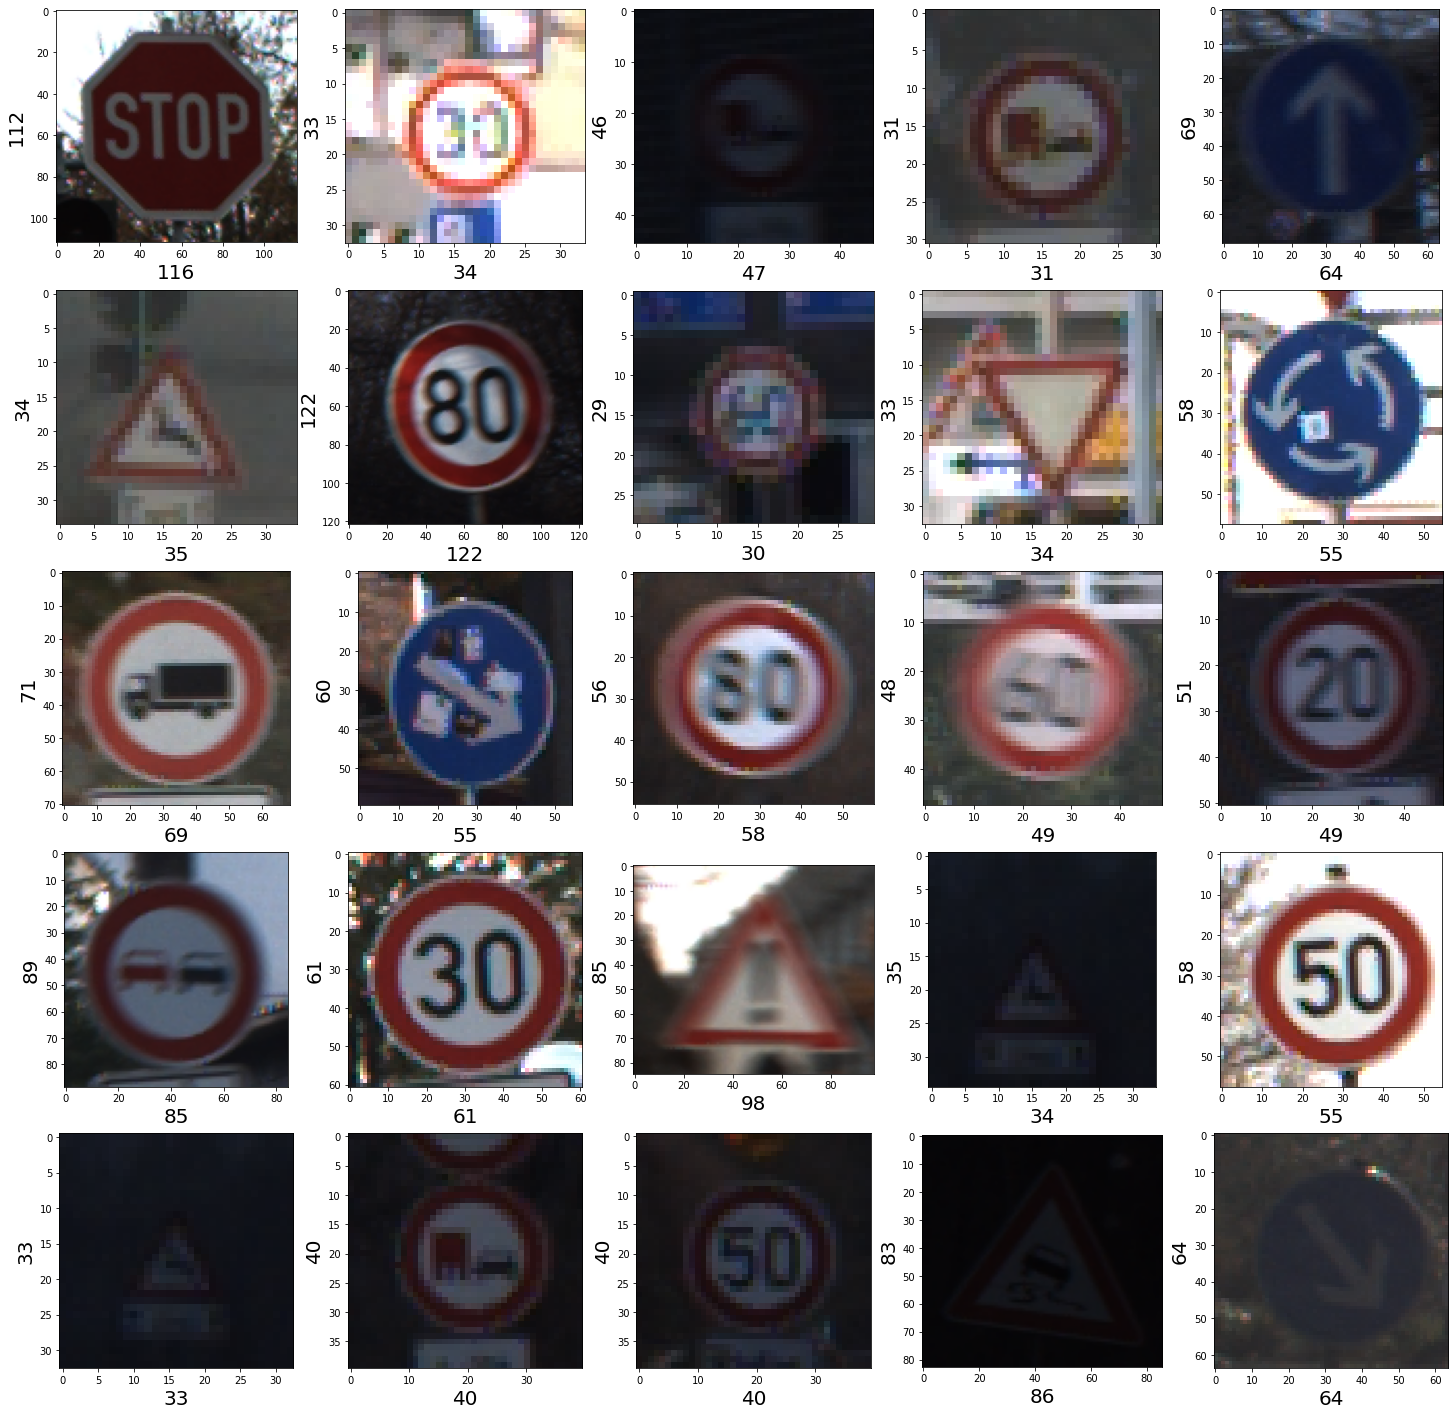

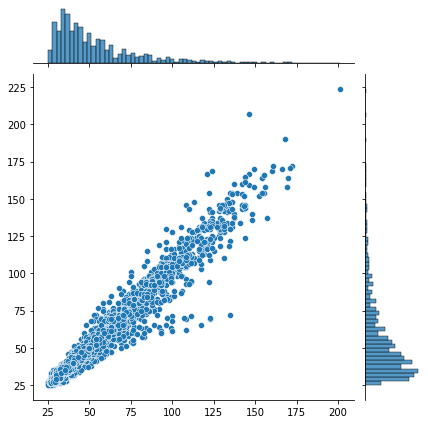

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


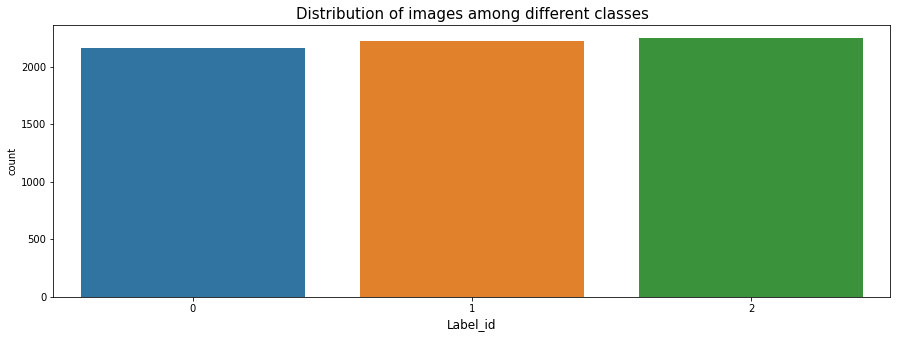

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          3

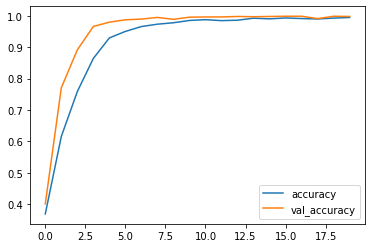

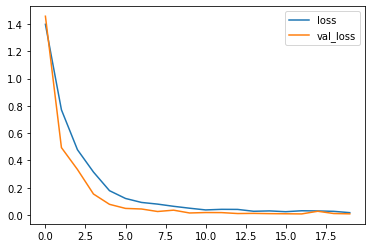

In [4]:

import pandas as pd
import tensorflow as tf
import keras
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
from PIL import Image


lab = pd.read_csv ('/content/TrafficSigns/Labels.csv')

print(lab)

dir_path = '/content/TrafficSigns'

os.listdir(dir_path)

# Assigning the path for train and test images

train_path = dir_path + '/Train'
test_path = dir_path + '/Test'

print(sorted(os.listdir(train_path)))

sorted(os.listdir(test_path))

# Visualizing 25 random sample images from test set


images_path = os.listdir(test_path)

plt.figure(figsize=(25, 25))

for i in range(1, 26):
    plt.subplot(5, 5, i)
    random_img_path = test_path + '/' + random.choice(images_path)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize=20)  # width of image
    plt.ylabel(rand_img.shape[0], fontsize=20)  # height of image

dim1 = []
dim2 = []

for i in range(0,3):
    labels = train_path + '/{0}'.format(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = imread(labels + '/' + x)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])


sns.jointplot(dim1, dim2)
plt.show()

np.mean(dim1)

np.mean(dim2)

# Since the mean of both dimensions is around 50 , we will use (50x50) as the shape of images.

image_shape = (50, 50)

images = []
label_id = []

for i in range(3):
    labels = train_path + '/{0}'.format(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = Image.open(labels + '/' + x)
        img = img.resize(image_shape)
        img = np.array(img)
        images.append(img)
        label_id.append(i)



#Converting images into numpy array
images = np.array(images)

images = images/255 


label_id = np.array(label_id)
label_id.shape

images.shape

plt.figure(figsize=(15,5))
sns.countplot(label_id)
plt.title('Distribution of images among different classes', fontsize = 15)
plt.xlabel('Label_id', fontsize=12)
plt.show()


np.save('Training_set', images)
np.save('Label_Id', label_id)


# Splitting the train data into train and validation data

images = np.load('Training_set.npy')
label_id = np.load('Label_Id.npy')


#Splitting the data

x_train, x_val, y_train, y_val = train_test_split(images, label_id , test_size = 0.2, random_state = 3)


y_train_cat = to_categorical(y_train)

y_val_cat = to_categorical(y_val)



# Model Building

model = Sequential()

#1st layer
model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = x_train.shape[1:], activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

#2nd layer
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

#3rd layer
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

#Dense layer
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))

#Output layer
model.add(Dense(43, activation = 'softmax'))


model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


model.summary()

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2)

model.fit(
    
    x_train, y_train,
    epochs = 20,
    batch_size = 64,
    validation_data = (x_val, y_val),
    #callbacks = [early_stopping],
    verbose = 2

)


#Saving the model
model.save('Model.h5')


# Model Evaluation

evaluation = pd.DataFrame(model.history.history)

evaluation[['accuracy', 'val_accuracy']].plot()
evaluation[['loss', 'val_loss']].plot()

# Testing on test data
model = load_model('Model.h5')






In [2]:

from zipfile import ZipFile
TrafficSigns = '/content/TrafficSigns.zip'

with ZipFile(TrafficSigns, 'r') as zip:
  zip.extractall()
  print('done')

done
